# 1 Introduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 What does your theory say about your data?

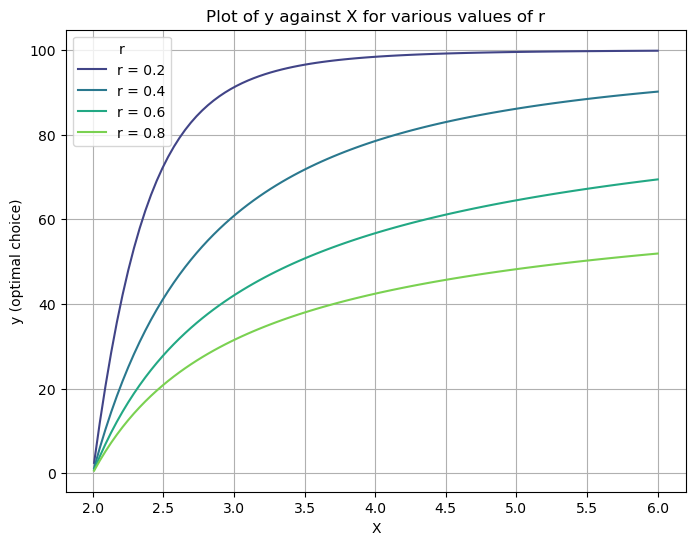

In [3]:
X = np.linspace(2.01, 6, num=100)
r = np.array([0.2,0.4,0.6,0.8])
X_grid, r_grid = np.meshgrid(X, r)

dplt1 = pd.DataFrame({
    'X': X_grid.ravel(),
    'r': r_grid.ravel(),
})

dplt1['y'] = 100 * (1 - (dplt1['X'] - 1) ** (-1/dplt1['r'])) / ((dplt1['X'] - 1) ** (1 - 1/dplt1['r']) + 1)
dplt1['r'] = 'r = ' + dplt1['r'].astype(str)

plt.figure(figsize=(8, 6))
sns.lineplot(data=dplt1, x='X', y='y', hue='r', palette='viridis')
plt.xlabel('X')
plt.ylabel('y (optimal choice)')
plt.title('Plot of y against X for various values of r')
plt.grid(True)
plt.show()

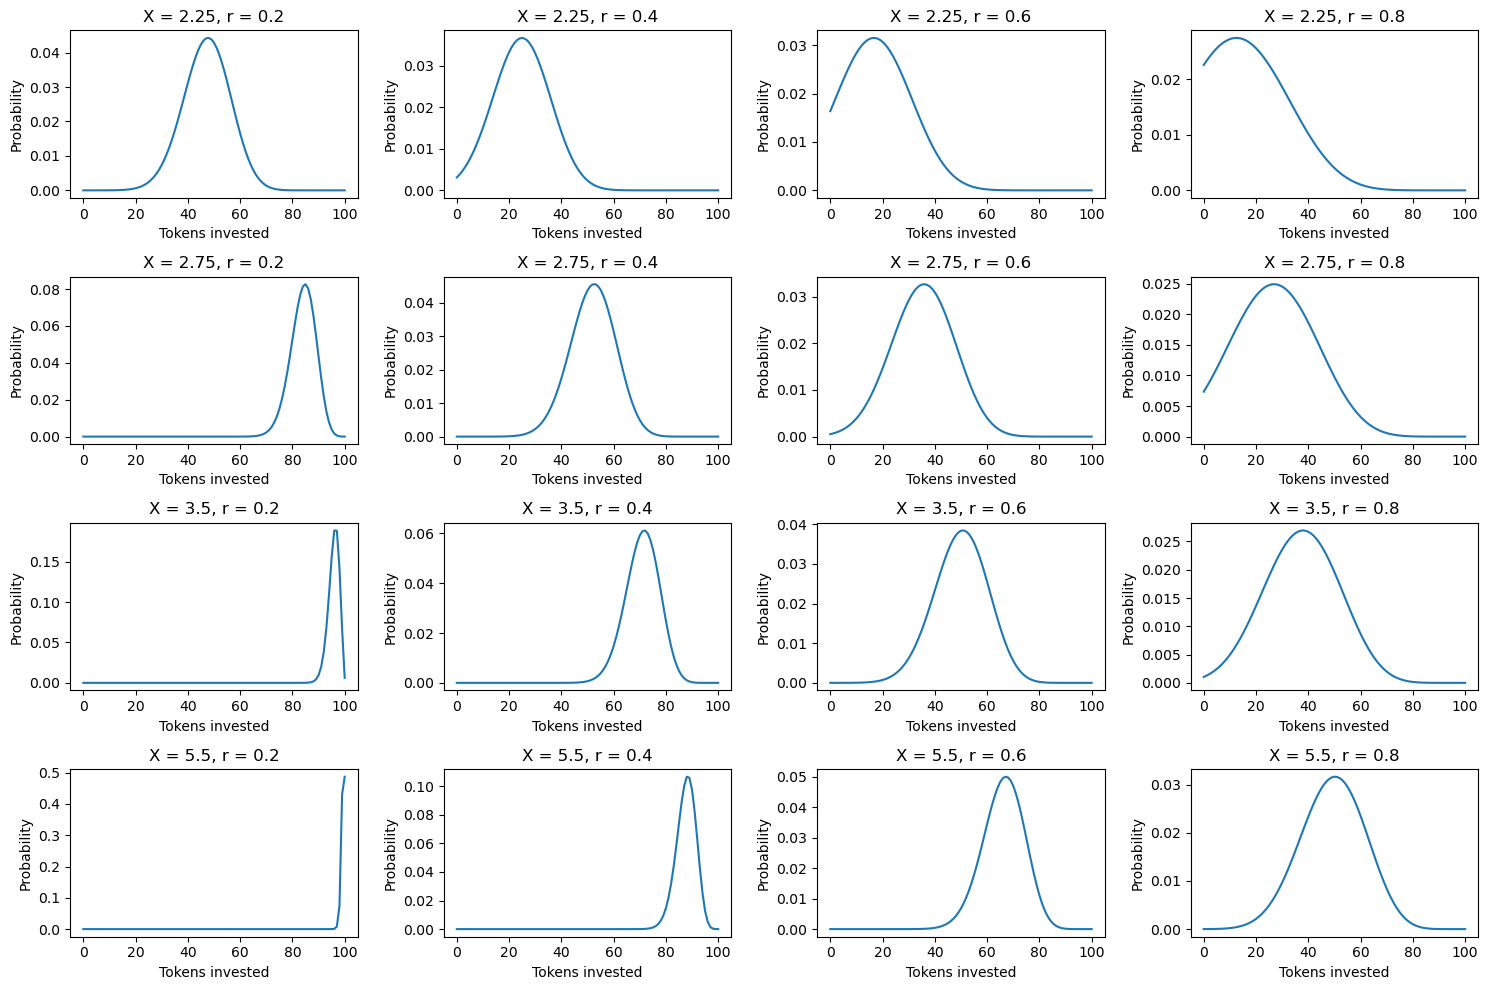

In [4]:
# Define the parameters
r_values = [0.2, 0.4, 0.6, 0.8]
X_values = [2.25, 2.75, 3.5, 5.5]
y_values = np.linspace(0, 100, 101)
_lambda = 10

# Create the initial DataFrame
df = pd.DataFrame([(X, y, r) for X in X_values 
                   for y in y_values 
                   for r in r_values], 
                  columns=['X', 'y', 'r'])

# Calculate EU
df['EU'] = 0.5 * (100 - df['y']) ** (1 - df['r']) / (1 - df['r']) + 0.5 * (100 + df['y'] * (df['X'] - 1)) ** (1 - df['r']) / (1 - df['r'])

# Calculate pr
df['pr'] = df.groupby(['X', 'r'])['EU'].transform(lambda x: np.exp(_lambda * (x - x.max())) / np.sum(np.exp(_lambda * (x - x.max()))))

# Create labels for X and r
df['X'] = 'X = ' + df['X'].astype(str)
df['r'] = 'r = ' + df['r'].astype(str)

# Create subplots
fig, axs = plt.subplots(len(r_values), len(X_values), figsize=(15, 10))

for ax, (group, group_df) in zip(axs.flat, df.groupby(['X', 'r'])):
    ax.plot(group_df['y'], group_df['pr'])
    ax.set_title(f'{group[0]}, {group[1]}')
    ax.set_xlabel('Tokens invested')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()

## 1.2 What do your data say about your theory?



In [6]:
import pystan

model_code = """
data {
  int<lower=0> n; // number of observations
  int<lower=0> ny; // size of the choice set
  int y[n];   // choices made by participant
  vector[n] X;   // multiplier for investment
  vector[ny] ygrid; // possible values of y (i.e. the choice set)
  real prior_r[2]; // prior mean and sd for r
  real prior_lambda[2]; // prior mean and sd for log(lambda)
}

parameters {
   real r; // parameter in CRRA utility function x^(1-r)/(1-r)
   real<lower=0> lambda; // logit choice precision
}

model {
  for (ii in 1:n) {
    vector[ny] EU; // expected utility of choosing each action
    vector[ny] lpr;// (log) probability of choosing each action
    for (jj in 1:ny) {
        EU[jj] = 0.5*pow(100-ygrid[jj],1.0-r)/(1.0-r)+0.5*pow(100+ygrid[jj]*(X[ii]-1),1.0-r)/(1.0-r);
    }
    lpr = log_softmax(lambda*EU);
    
    target+=lpr[y[ii]];
  }
  
  // specify the priors for the parameters
  r ~ normal(prior_r[1],prior_r[2]);
  lambda ~ lognormal(prior_lambda[1],prior_lambda[2]);
}
"""

# compile the model
sm = pystan.StanModel(model_code=model_code)

# prepare data for Stan model
data = {
    'n': n,
    'ny': ny,
    'y': y,
    'X': X,
    'ygrid': ygrid,
    'prior_r': prior_r,
    'prior_lambda': prior_lambda
}

# fit the model to data
fit = sm.sampling(data=data, iter=1000, chains=4)

# print the results
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb9a1f9bf1657d0bfdeaf7e7f181ab18 NOW.
In file included from /var/folders/nx/d9n0gf_554336p4pb53tds9c0000gn/T/pystan_3r63at4q/stanfit4anon_model_eb9a1f9bf1657d0bfdeaf7e7f181ab18_8756647150679131210.cpp:1280:
In file included from /Users/plodmatics/anaconda3/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/plodmatics/anaconda3/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/plodmatics/anaconda3/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940:
/Users/plodmatics/anaconda3/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/nx/d9n0gf_554336p4pb53tds9c

NameError: name 'n' is not defined